In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline
# to render images in gray 
plt.gray()

<Figure size 432x288 with 0 Axes>

Below is used to convert image to grayscale

In [2]:
# from PIL import Image, ImageOps
# image = Image.open("StMiMo_Hudson_960.jpg")

# # applying grayscale method
# gray_image = ImageOps.grayscale(image)
# gray_image.save('StMiMo_Hudson_960_grayscale.jpg')
# gray_image.show()

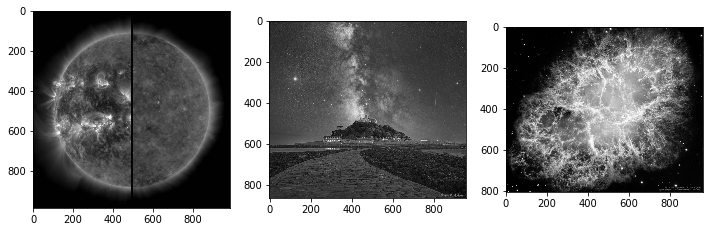

In [3]:
# https://apod.nasa.gov/apod/ap200917.html
sun = mpimg.imread('ig_maxmin_grayscale.jpg')
# https://apod.nasa.gov/apod/ap200907.html
mount = mpimg.imread('StMiMo_Hudson_960_grayscale.jpg')
# https://apod.nasa.gov/apod/ap200906.html
nebula = mpimg.imread('nebula_grayscale.jpg')
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,3,1)
ax.imshow(sun)
ax = fig.add_subplot(1,3,2)
ax.imshow(mount)
ax = fig.add_subplot(1,3,3)
ax.imshow(nebula)

Functions from previous assignment

In [4]:
from collections import defaultdict
def compute_histogram(img):
    width = img.shape[1]
    height = img.shape[0]
    histogram = defaultdict(lambda:0)
    for row in img:
        for pixel_value in row:
            if pixel_value > 255:
                pixel_value = 255
            if pixel_value < 0:
                pixel_value = 0
            histogram[pixel_value]+=1
    return histogram

def plot_histogram(image):
    plt.figure(figsize=(15,5))
    histogram = compute_histogram(image)
    plt.bar(histogram.keys(), histogram.values(), width=1)

In [5]:
def plot_two_histograms(image, new_image):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title('Original Histogram')
    orig_histogram = compute_histogram(image)
    ax.bar(orig_histogram.keys(), orig_histogram.values(), width=1)
    
    new_histogram = compute_histogram(new_image)
    ax = fig.add_subplot(2, 1, 2)
    ax.set_title('New Histogram')
    ax.bar(new_histogram.keys(), new_histogram.values(), width=1)

In [6]:
# reference - https://en.wikipedia.org/wiki/Thresholding_(image_processing)
# automatic thresholding
def global_thresholding(image):
    previous_threshold = 0
    new_threshold = 128
    epsilon = 0.1
    width, height = image.shape[1], image.shape[0]
    while abs(new_threshold-previous_threshold) > epsilon:
        greater_pixels_sum = 0
        lesser_pixels_sum = 0
        greater_pixels_count = 0
        lesser_pixels_count = 0
        for row in range(height):
            for col in range(width):
                if image[row][col] > new_threshold:
                    greater_pixels_sum += image[row][col]
                    greater_pixels_count += 1
                else:
                    lesser_pixels_sum += image[row][col]
                    lesser_pixels_count += 1
        previous_threshold = new_threshold
        new_threshold = 0
        if lesser_pixels_count > 0:
            new_threshold += lesser_pixels_sum/lesser_pixels_count
        if greater_pixels_count > 0:
            new_threshold += greater_pixels_sum/greater_pixels_count
        new_threshold /= 2
        #print(previous_threshold, new_threshold)
    return new_threshold

In [7]:
def binarize_image_using_given_threshold(image, threshold):
    histogram = compute_histogram(image)
    width, height = image.shape[1], image.shape[0]
    binary_image = np.zeros((height,width), dtype='int')
    for row in range(height):
        for col in range(width):
            binary_image[row][col] = 1 if image[row][col] > threshold else 0
    return binary_image

In [8]:
def binarize_image_using_global_thresholding(image):
    histogram = compute_histogram(image)
    width, height = image.shape[1], image.shape[0]
    binary_image = np.zeros((height,width), dtype='int')
    threshold = round(global_thresholding(image))
    for row in range(height):
        for col in range(width):
            binary_image[row][col] = 1 if image[row][col] > threshold else 0
    return binary_image

In [9]:
# taking complement of binary image i.e 0->1 and 1->0
def get_complement_image(image):
    width, height = image.shape[1], image.shape[0]
    binary_image_complement = np.zeros((height,width), dtype='int')
    for row in range(height):
        for col in range(width):
            binary_image_complement[row][col] = int(not image[row][col])
    return binary_image_complement

In [10]:
# returns true if given coordinates is within image
def is_in_range(x, y, width, height):
    if x < 0 or y < 0  or x >= height or y >= width:
        return False
    return True

# finding nearest neigbour inside image of given coordinate if 
# given coordinate is outside the image
def replicate_with_nearest_neighbour(x, y, width, height):
    nearest_x, nearest_y = 0, 0
    if x>=0 and x<width:
        nearest_x = x
        nearest_y = 0 if abs(y-0)<abs(y-(height-1)) else (height-1)
        return (nearest_x, nearest_y)
    if y>=0 and y<height:
        nearest_x = 0 if abs(x-0)<abs(x-(width-1)) else (width-1)
        nearest_y = y
        return (nearest_x, nearest_y)
    nearest_x = 0 if abs(x-0)<abs(x-(width-1)) else (width-1)
    nearest_y = 0 if abs(y-0)<abs(y-(height-1)) else (height-1)
    return (nearest_x, nearest_y)

# dilate filter
def dilate_filter(binary_image, window):
    width, height = binary_image.shape[1], binary_image.shape[0]
    dilated_image = np.zeros((height,width), dtype='int')
    for row in range(height):
        for col in range(width):
            pixel_value = 0
            # taking bitwise OR of all pixel inside window
            for shifts in window:
                shift_x, shift_y = shifts[0], shifts[1]
                if is_in_range(row-shift_x, col-shift_y, width, height):
                    pixel_value |= binary_image[row-shift_x][col-shift_y]
                else:
                    nearest_x, nearest_y = replicate_with_nearest_neighbour(row-shift_x, col-shift_y, width, height)
                    pixel_value |= binary_image[nearest_y][nearest_x]
            dilated_image[row][col] = pixel_value
    return dilated_image

# erode filter
def erode_filter(binary_image, window):
    width, height = binary_image.shape[1], binary_image.shape[0]
    eroded_image = np.zeros((height,width), dtype='int')
    for row in range(height):
        for col in range(width):
            pixel_value = (1<<8)-1
            # taking bitwise AMD of all pixel inside window
            for shifts in window:
                shift_x, shift_y = shifts[0], shifts[1]
                if is_in_range(row-shift_x, col-shift_y, width, height):
                    pixel_value &= binary_image[row-shift_x][col-shift_y]
                else:
                    nearest_x, nearest_y = replicate_with_nearest_neighbour(row-shift_x, col-shift_y, width, height)
                    pixel_value &= binary_image[nearest_y][nearest_x]
            eroded_image[row][col] = pixel_value
    return eroded_image

# median filter
def median_filter(binary_image, window):
    width, height = binary_image.shape[1], binary_image.shape[0]
    median_image = np.zeros((height,width), dtype='int')
    for row in range(height):
        for col in range(width):
            # list of all pixels inside window
            window_values = []
            for shifts in window:
                shift_x, shift_y = shifts[0], shifts[1]
                if is_in_range(row-shift_x, col-shift_y, width, height):
                    window_values.append(binary_image[row-shift_x][col-shift_y])
                else:
                    nearest_x, nearest_y = replicate_with_nearest_neighbour(row-shift_x, col-shift_y, width, height)
                    window_values.append(binary_image[nearest_y][nearest_x])
            # finding median of all pixels inside window
            median_image[row][col] = np.median(window_values)
    return median_image

In [11]:
# CROSS(5)
CROSS_5 = [[0,0], [0,-1], [0,-2], [0,1], [0,2], [1,0], [2, 0], [-1, 0], [-2,0]]
# SQUARE(3)
SQUARE_3 = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]]

# 1) Binary Morphology

In [12]:
# checks if images are same or not
def difference_of_images(img1, img2):
    height_1, width_1 = img1.shape[0], img1.shape[1]
    height_2, width_2 = img2.shape[0], img2.shape[1]
    # if height or width are different for two images, then they are not same
    if(height_1 != height_2 or width_1 != width_2):
        return False 
    difference  = 0
    # checking if every pixel of two images are same or not
    for row in range(height_1):
        for col in range(width_1):
            difference += img1[row][col] != img2[row][col]
    return (difference == 0)

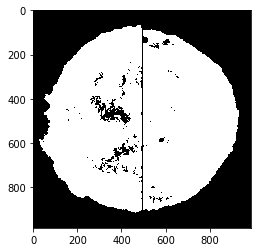

In [13]:
binary_image = binarize_image_using_global_thresholding(sun)
plt.imshow(binary_image)

Write code to verify that:
1. DILATE is the dual of ERODE with respect to complementation.

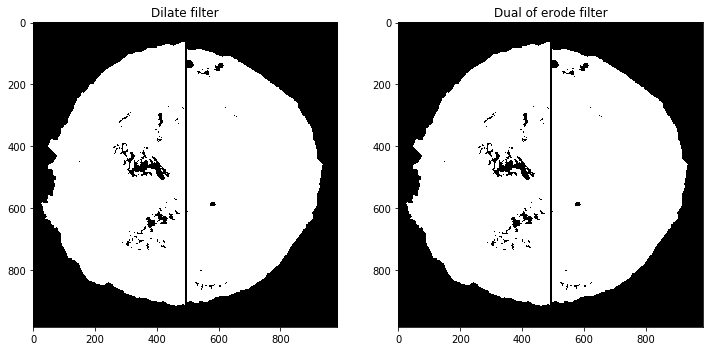

In [14]:
# dilated image
dilated_image = dilate_filter(binary_image, SQUARE_3)

# dual of erode
# first taking complement, applying erode filter, again taking complement
complement_image = get_complement_image(binary_image)
eroded_image = erode_filter(complement_image, SQUARE_3)
complement_eroded_image = get_complement_image(eroded_image)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,2,1)
ax.set_title('Dilate filter')
ax.imshow(dilated_image)
ax = fig.add_subplot(1,2,2)
ax.set_title('Dual of erode filter')
ax.imshow(complement_eroded_image)

In [15]:
# checking if images are same or not
if difference_of_images(dilated_image, complement_eroded_image):
    print("Images are same")

Images are same


2. ERODE is the dual of DILATE with respect to complementation.

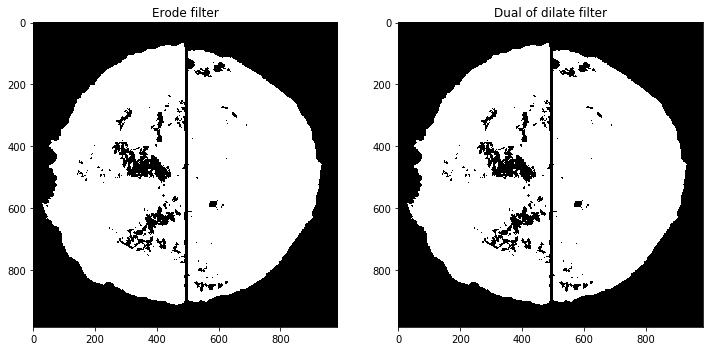

In [16]:
# eroded image
eroded_image = erode_filter(binary_image, SQUARE_3)

# dual of dilate
# first taking complement, applying dilate filter, again taking complement
complement_image = get_complement_image(binary_image)
dilated_image = dilate_filter(complement_image, SQUARE_3)
complement_dilated_image = get_complement_image(dilated_image)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,2,1)
ax.set_title('Erode filter')
ax.imshow(eroded_image)
ax = fig.add_subplot(1,2,2)
ax.set_title('Dual of dilate filter')
ax.imshow(complement_dilated_image)

In [17]:
# checking if images are same or not
if difference_of_images(eroded_image, complement_dilated_image):
    print("Images are same")

Images are same


3. MEDIAN is its own dual with respect to complementation.

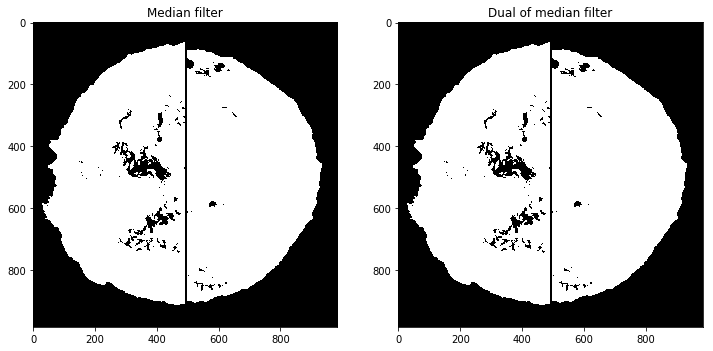

In [18]:
# median filter applied
median_image = median_filter(binary_image, SQUARE_3)

# dual of median filter
# first taking complement, applying median filter, again taking complement
complement_image = get_complement_image(binary_image)
median_complement_image = median_filter(complement_image, SQUARE_3)
complement_median_image = get_complement_image(median_complement_image)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,2,1)
ax.set_title('Median filter')
ax.imshow(median_image)
ax = fig.add_subplot(1,2,2)
ax.set_title('Dual of median filter')
ax.imshow(complement_median_image)

In [19]:
# checking if images are same or not
if difference_of_images(median_image, complement_median_image):
    print("Images are same")

Images are same


Verify this by showing that the difference between the images from the direct and complement paths is
indeed zero.

In [20]:
if difference_of_images(dilated_image, complement_eroded_image):
    print("Images are same")

In [21]:
if difference_of_images(eroded_image, complement_dilated_image):
    print("Images are same")

Images are same


In [22]:
if difference_of_images(median_image, complement_median_image):
    print("Images are same")

Images are same


# 2) Gray scale operations

Perform simple linear point operations for the following cases:

In [23]:
# linear point operation J = P*I + L
def linear_point_operation(image, P, L):
    height, width = image.shape[0], image.shape[1]
    new_image = np.zeros((height, width))
    for row in range(height):
        for col in range(width):
            new_image[row][col] = P*image[row][col] + L
    return new_image

While doing linear point operations if pixel value becomes greater than 255 then it is capped to 255 and <br>
if it becomes less than 0 it is capped to 0.

(a) J = P.I

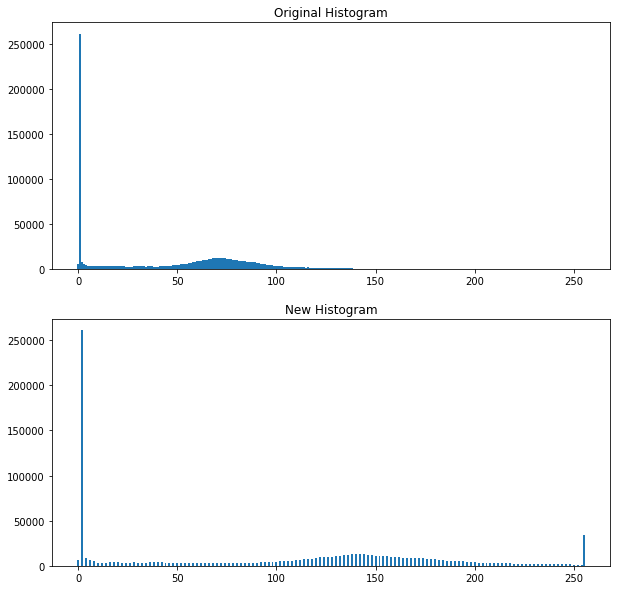

In [24]:
scaled_up_image = linear_point_operation(sun, 2, 0)
plot_two_histograms(sun, scaled_up_image)

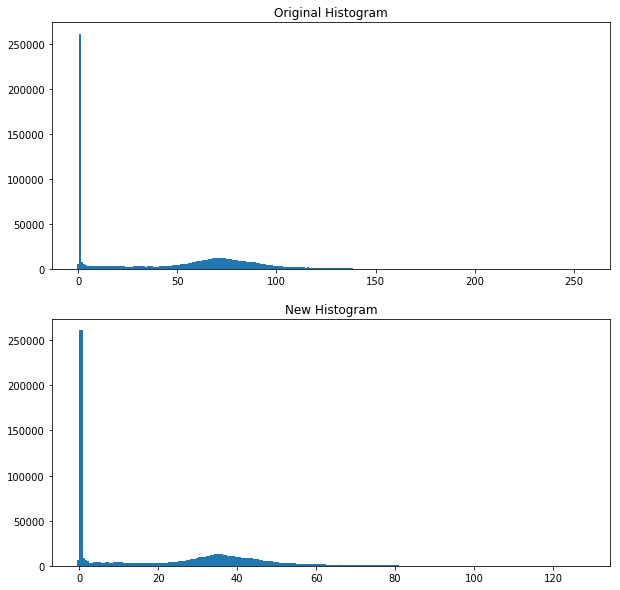

In [25]:
scaled_down_image = linear_point_operation(sun, 1/2, 0)
plot_two_histograms(sun, scaled_down_image)

(b) J = I + L.

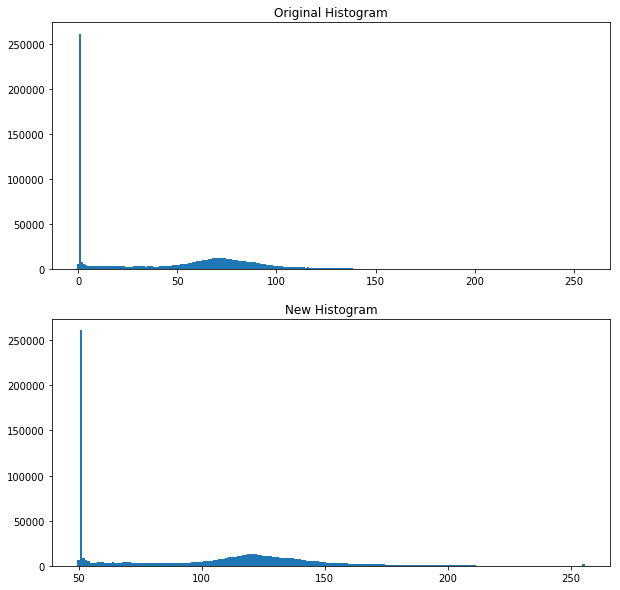

In [26]:
offset_image = linear_point_operation(sun, 1, 50)
plot_two_histograms(sun, offset_image)

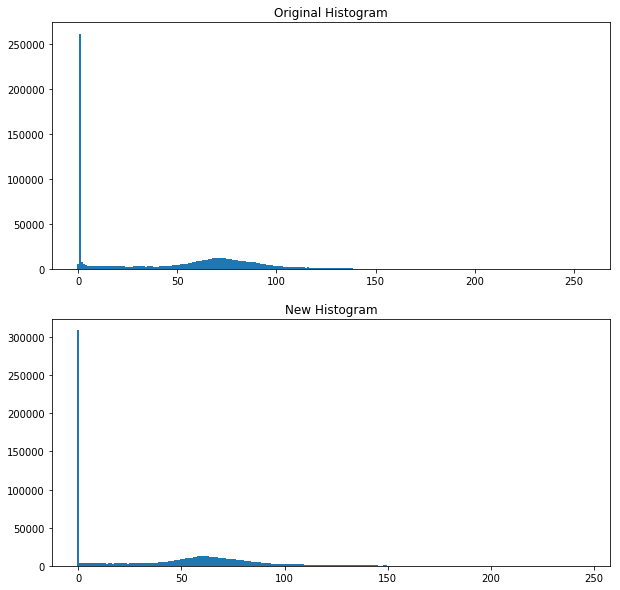

In [27]:
offset_image = linear_point_operation(sun, 1, -10)
plot_two_histograms(sun, offset_image)

As observed in above histogram, the histogram is shifted to right by 50 levels. Hence just adding L to intensity shifts the histogram by L levels.

In each case, verify that the histogram of J is related to the histogram of I according to the relation
discussed in class.

As observed in first histogram (scaled), the histogram is scaled down in case of P<1 and scaled up in case of P>1 i.e. range is scaled up or down P times.

As observed in second histogram (offset), the histogram is shifted to right by 50 levels if L is positive and to left if L is neagtive. Hence just adding L shifts the histogram.

Full scale contrast stretch (FSCS). Verify your result by printing the min and max pixel values before
and after applying FSCS. Also, plot the histogram of the image before and after applying FSCS.

In [28]:
# full scale contrast stretch
def FSCS(image):
    height, width = image.shape[0], image.shape[1]
    min_pixel_value = np.min(image)
    max_pixel_value = np.max(image)
    K = 256
    P = (K-1)/(max_pixel_value-min_pixel_value)
    L = (-1*min_pixel_value)*(K-1)/(max_pixel_value-min_pixel_value)
    new_image = linear_point_operation(image, P, L)
    return new_image

Sun

In [29]:
fscs_image = FSCS(sun)
print("Maximum pixel value of new image is " + str(np.max(fscs_image)) + " and minimum pixel value of new image is "+ str(np.min(fscs_image)))

Maximum pixel value of new image is 255.0 and minimum pixel value of new image is 0.0


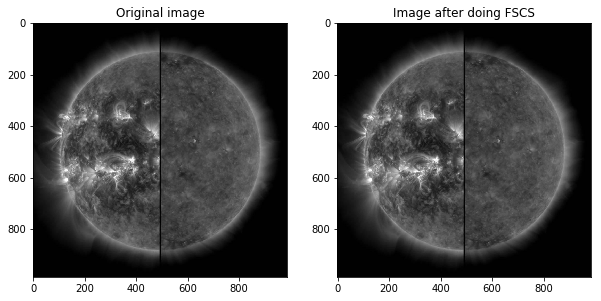

In [30]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,2,1)
ax.set_title('Original image')
ax.imshow(sun)
ax = fig.add_subplot(1,2,2)
ax.set_title('Image after doing FSCS')
ax.imshow(fscs_image)

No considerable changes are seen in above teo images except some high intensity pixels became <br>
more bright and less intensity pixels became less bright <br>

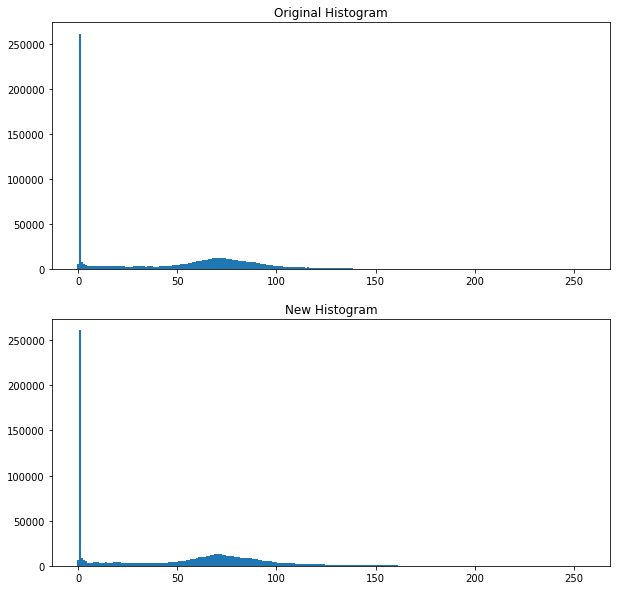

In [31]:
plot_two_histograms(sun, fscs_image)

Mount

In [32]:
fscs_image = FSCS(mount)
print("Maximum pixel value of new image is " + str(np.max(fscs_image)) + " and minimum pixel value of new image is "+ str(np.min(fscs_image)))

Maximum pixel value of new image is 255.0 and minimum pixel value of new image is 0.0


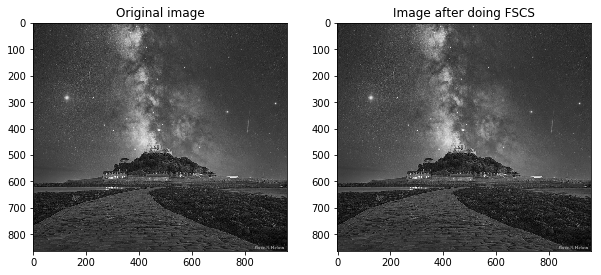

In [33]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,2,1)
ax.set_title('Original image')
ax.imshow(mount)
ax = fig.add_subplot(1,2,2)
ax.set_title('Image after doing FSCS')
ax.imshow(fscs_image)

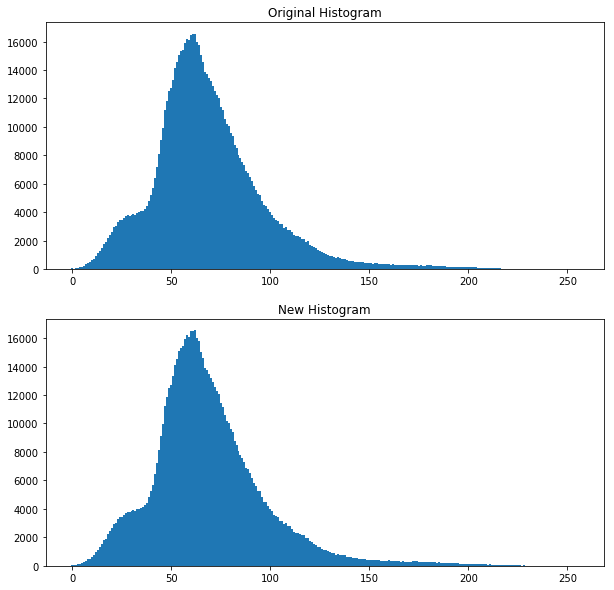

In [34]:
plot_two_histograms(mount, fscs_image)

As observed in above histogram, the pixel value range is increased i.e minimum pixel value becomes 0 <br>
and maximum pixel value becomes 255.

Log magnitude compression (always followed by FSCS). Plot the histogram of the image before and
after applying log magnitude compression.

In [35]:
# log magnitude compression 
def log_compression(image):
    height, width = image.shape[0], image.shape[1]
    log_compressed_image = np.zeros((height, width), dtype='int')
    for row in range(height):
        for col in range(width):
            log_compressed_image[row][col] = np.log2(1+image[row][col])
    return log_compressed_image

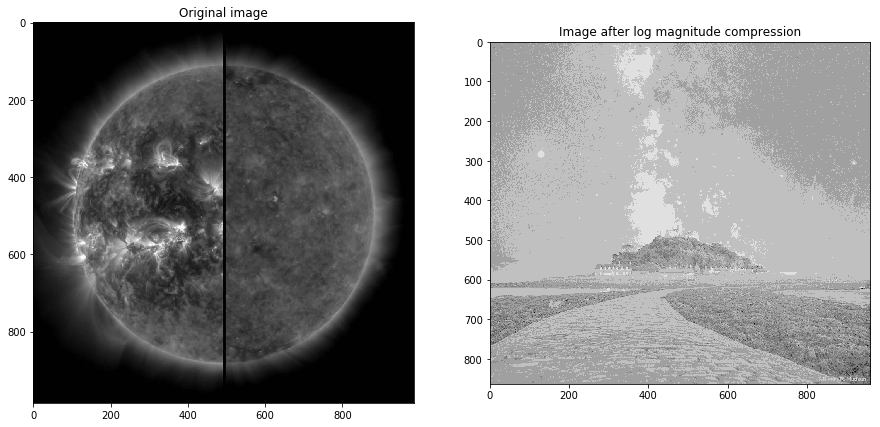

In [36]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,2,1)
ax.set_title('Original image')
ax.imshow(sun)
ax = fig.add_subplot(1,2,2)
ax.set_title('Image after log magnitude compression')
log_compressed_image = log_compression(fscs_image)
ax.imshow(log_compressed_image)

After doing log magnitude compression, bright pixels are compressed and faint pixels are emerged. <br>
Since range of pixel values are decreased, we notice less grayscale levels being used in images <br>
hence isnt as good as original. 

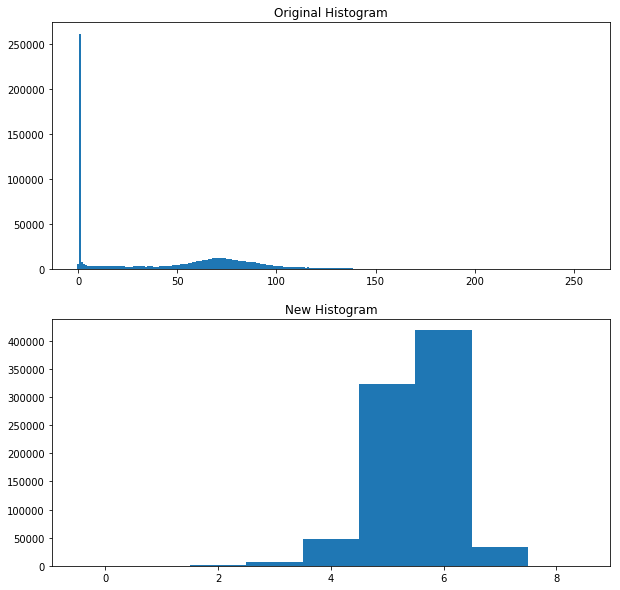

In [37]:
plot_two_histograms(sun, log_compressed_image)

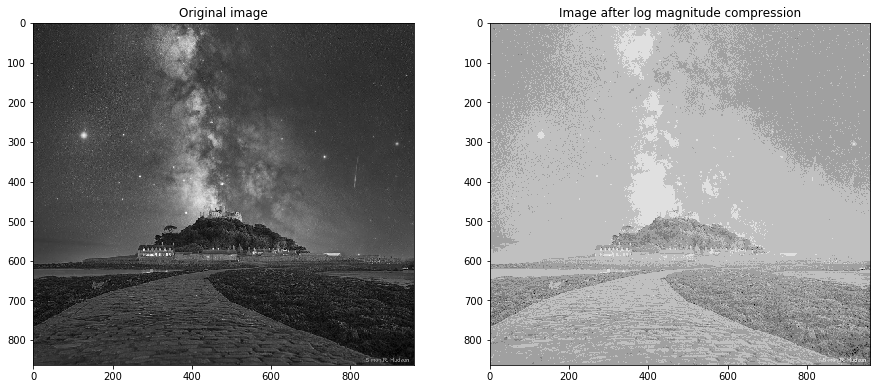

In [38]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,2,1)
ax.set_title('Original image')
ax.imshow(mount)
ax = fig.add_subplot(1,2,2)
ax.set_title('Image after log magnitude compression')
fscs_image = FSCS(mount)
log_compressed_image = log_compression(fscs_image)
ax.imshow(log_compressed_image)

After doing log magnitude compression, bright pixels are compressed and faint pixels are emerged. <br>
Since range of pixel values are decreased, we notice less grayscale levels being used in images <br>
hence isnt as good as original. 

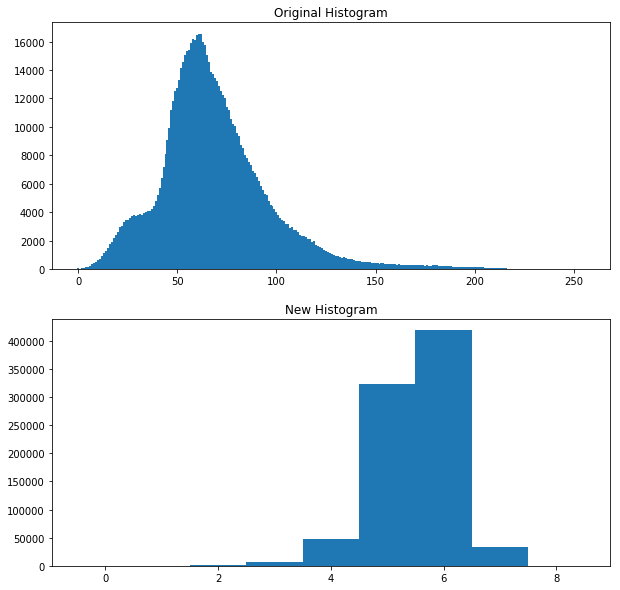

In [39]:
plot_two_histograms(mount, log_compressed_image)

Log magnitude compression thus non linearly compresses and equalizes the gray level scales. That is, bright<br>
pixels are compressed and faint pixels are emerged.

Thus histogram obtained after doing log magnitude compression have decreased range i.e minimum pixel value <br> 
becomes log of the pixel value and same of maximum. It looks more like bar plots with multiple bars.

Histogram flattening. Plot the histogram of the image before and after applying histogram flattening.

In [40]:
# histogram flattening
def histogram_flattening(image):
    height, width = image.shape[0], image.shape[1]
    histogram = compute_histogram(image)
    
    fig = plt.figure(figsize=(10,10))
    
    pmf_histogram = np.zeros(256)
    cdf_histogram = np.zeros(256)
    # calculating pmf of histogram 
    for level, freq in histogram.items():
        pmf_histogram[level] = freq/(height*width)
    # checking if sum of all levels in pmf is 1
    assert(abs(np.sum(pmf_histogram) - 1) <= 0.001)
    #print(np.sum(pmf_histogram))
    
    ax = fig.add_subplot(2,1,1)
    ax.set_title('pmf distribution')
    ax.bar(range(0,256), pmf_histogram, width=1)
    
    # calculating cdf of histogram 
    cdf_histogram[0] = pmf_histogram[0]
    for level in range(1, 256):
        cdf_histogram[level] = cdf_histogram[level-1] + pmf_histogram[level]
    # checking if last level in cdf is 1
    assert(abs(cdf_histogram[255] - 1) <= 0.001)
    #print(cdf_histogram)
    
    ax = fig.add_subplot(2,1,2)
    ax.set_title('cdf distribution')
    ax.bar(range(0,256), cdf_histogram, width=1)
    
    # replacing pixel value in new image with cdf of the pixel value at that location
    new_image = np.zeros((height, width))
    for row in range(height):
        for col in range(width):
            new_image[row][col] = cdf_histogram[image[row][col]]
    
    # doing FSCS on image
    fscs_image = FSCS(new_image)
    #fscs_histogram = compute_histogram(fscs_image)
    return fscs_image

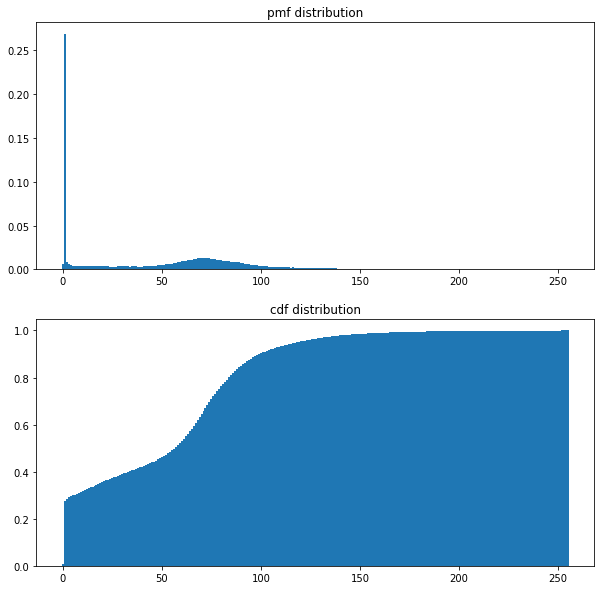

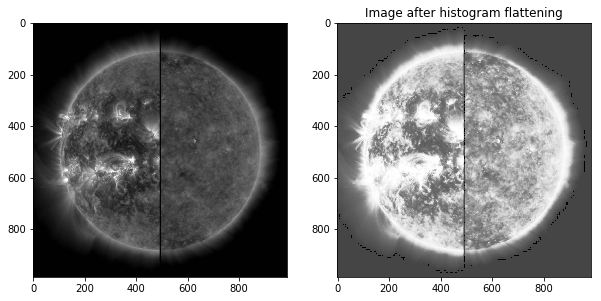

In [41]:
flattened_histogram_img = histogram_flattening(sun)
fig = plt.figure(figsize=(10,10))
ax.set_title("Original image")
ax = fig.add_subplot(1,2,1)
ax.imshow(sun)
ax = fig.add_subplot(1,2,2)
ax.set_title("Image after histogram flattening")
ax.imshow(flattened_histogram_img)

As in above images, the contrast of image after histogram flattening is increased. Since it spreads out <br>
intensity values. Hence low intensity pixels gain contrast. Hence overall contrast of image is <br>
increased.

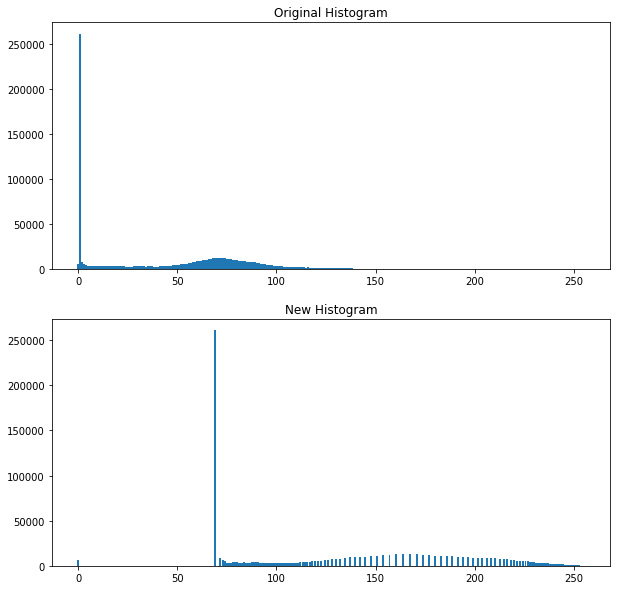

In [42]:
plot_two_histograms(sun, flattened_histogram_img)

As we can see in above histogram, the pixel values spread out however peak is retained since <br>
those many pixels would have same cdf value hence peak would be retained in new histogram also. ,br>
Also, gaps are introduced in histogram since cdf values are different for nearby levels. <br>
Hence, those levels in the gap region have no pixels equal to those levels.

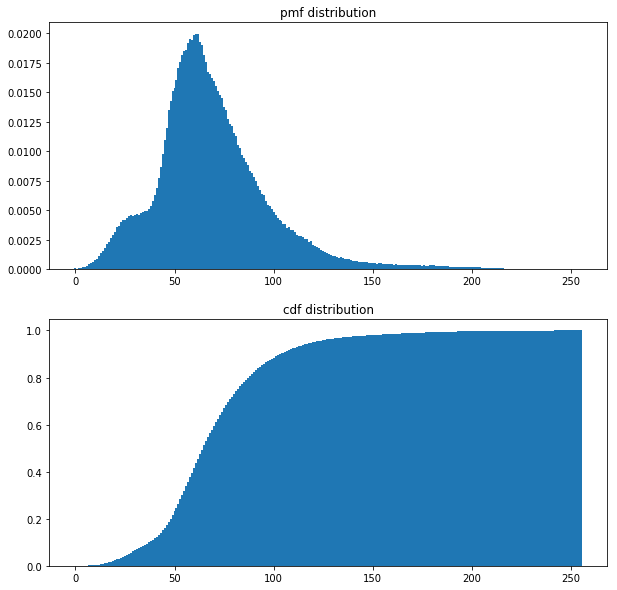

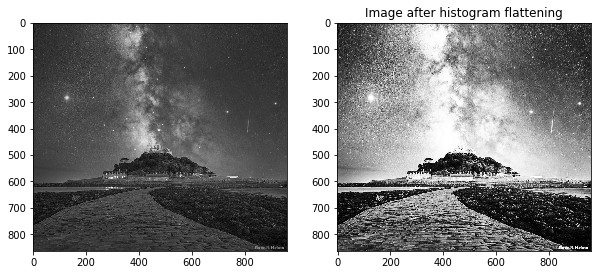

In [43]:
flattened_histogram_img = histogram_flattening(mount)
fig = plt.figure(figsize=(10,10))
ax.set_title("Original image")
ax = fig.add_subplot(1,2,1)
ax.imshow(mount)
ax = fig.add_subplot(1,2,2)
ax.set_title("Image after histogram flattening")
ax.imshow(flattened_histogram_img)

As in above images, the contrast of image after histogram flattening is increased. Since it spreads out <br>
intensity values. Hence low intensity pixels gain contrast. Hence overall contrast of image is <br>
increased. 

As in above images, the contrast of image after histogram flattening is increased. Since it spreads out <br>
intensity values. Hence low intensity pixels gain contrast.

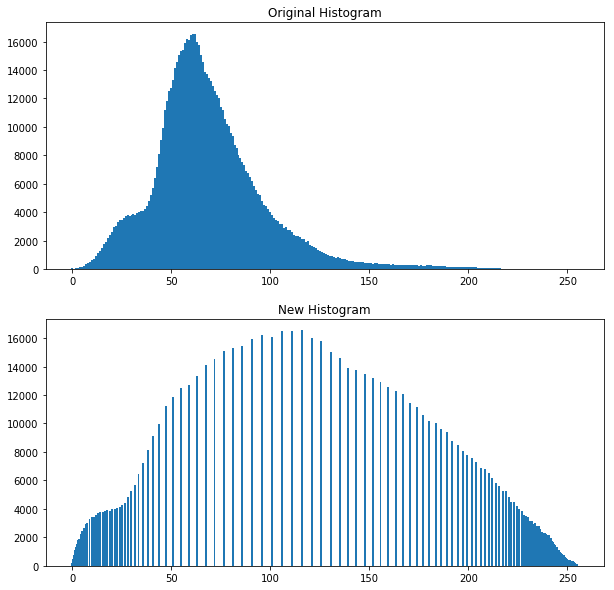

In [44]:
plot_two_histograms(mount, flattened_histogram_img)

As in above histogram, more frequent intensity values are spread out

Now test your implementation using copyright-free images from NASA’s site. Compare the original image
with the output of each of the three operations above. Comment on the quality of the original images based
on the output of these operations. Make sure your image display function doesn’t do any further contrast
stretching. <br>
Also, gaps are introduced in histogram since cdf values are different for nearby levels. <br>
Hence, those levels in the gap region have no pixels equal to those levels.

Tested all techniques on two images above

# 3) Zooming

Write a program to zoom an image by 1.5 times along each axis using the following techniques discussed
in class:

Nearest neighbor

In [45]:
# method 1
# Iterating over each pixel of zoomed image and dividing its coordinate
# by zoom factor and flooring it to find pixel of original image it correspond to
# For example, if original image is 10*10 and zoom_factor is 1.5,
# new image would be 15*15. So for finding pixel value at (10,10)
# it would assign pixel value at (6,6) of original image

# This method uniformly inserts pixels of original image in new image, and 
# for remaining coordinates pixels values are same as its left neigbour in original 
# image
# complexity - O(m*n) since for we are iterating over each pixel
def zoom_image_nearest_neighbour_1(image, zoom_factor):
    width, height = int(image.shape[1]*zoom_factor), int(image.shape[0]*zoom_factor)
    zoomed_image = np.zeros((height, width))
    for row in range(height):
        for col in range(width):
            zoomed_image[row][col] = image[int(row/zoom_factor)][int(col/zoom_factor)]
    return zoomed_image

In [46]:
# method 2
# Its same as above method except it replaces the pixel value with pixel value
# of nearest neigbour either to left or right in x-direction and up or down in y-direction.
# That is it rounds of fractional values to its nearest integer.
# For example if finding pixel value at (10,10), it will replace it with
# (round((10*2)/3), round((10*2)/3)) = (7,7) of original image
# complexity - O(m*n) since for we are iterating over each pixel
def zoom_image_nearest_neighbour_2(image, zoom_factor):
    orig_width, orig_height = image.shape[1], image.shape[0]
    width, height = int(image.shape[1]*zoom_factor), int(image.shape[0]*zoom_factor)
    zoomed_image = np.zeros((height, width))
    for row in range(height):
        for col in range(width):
            x = round(row/zoom_factor)
            y = round(col/zoom_factor)
            if x >= orig_height:
                x = orig_height-1
            if y >= orig_width:
                y = orig_width-1
            zoomed_image[row][col] = image[x][y]
    return zoomed_image

In [47]:
# method 3
# It randomly assign pixels value by pixel value of its nearest four neighbours
# i.e. top left, top right, bottom left, bottom right
# For eg, to find pixel value at (10,10) -> (10/1.5, 10/1.5) -> (6.6,6.6)
# So top left neighbour is (6,6) and top right neighbour is (7,6)
# So bottom left neighbour is (6,7) and bottom right neighbour is (7,7)
# And if pixel coordinates are not fractional then it replaces it with pixel value
# original image.
def zoom_image_nearest_neighbour_3(image, zoom_factor):
    orig_width, orig_height = image.shape[1], image.shape[0]
    width, height = int(image.shape[1]*zoom_factor), int(image.shape[0]*zoom_factor)
    zoomed_image = np.zeros((height, width))
    for row in range(height):
        for col in range(width):
            # when either of row or col is divisible by zoom_factor
            if row%zoom_factor == 0 or col% zoom_factor == 0:
                zoomed_image[row][col] = image[int(row/zoom_factor)][int(col/zoom_factor)]
            else:
                # both x and y are fractional
                x = row/zoom_factor
                y = col/zoom_factor
                left_top_neigbour = [int(x),int(y)]
                left_bottom_neigbour = [int(x),int(y)+1]
                right_top_neigbour = [int(x)+1,int(y)]
                right_bottom_neigbour = [int(x)+1,int(y)+1]
                neigbours = [left_top_neigbour, left_bottom_neigbour, right_top_neigbour, right_bottom_neigbour]
                # randomly choosing any of four nearest neigbours
                random_neighbour = neigbours[np.random.randint(0,4)]
                if random_neighbour[0] >= orig_height:
                    random_neighbour[0] = orig_height-1
                if random_neighbour[1] >= orig_width:
                    random_neighbour[1] = orig_width-1
                zoomed_image[row][col] = image[random_neighbour[0]][random_neighbour[1]]
    return zoomed_image

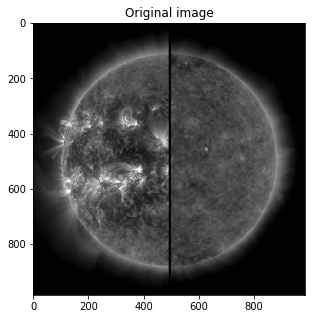

In [48]:
plt.figure(figsize=(5, 5))
plt.title('Original image')
plt.imshow(sun)

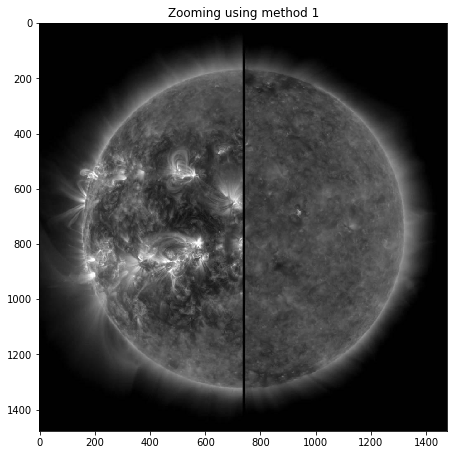

In [49]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_1(sun, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 1')
plt.imshow(zoomed_image)

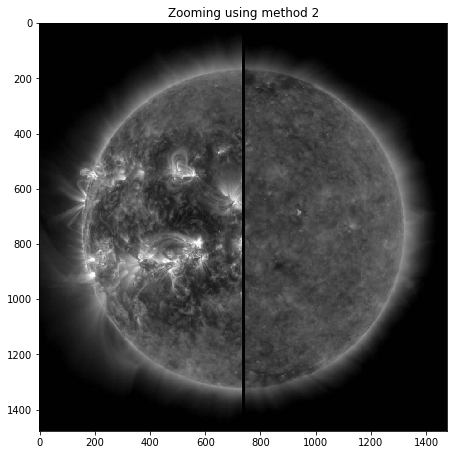

In [50]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_2(sun, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 2')
plt.imshow(zoomed_image)

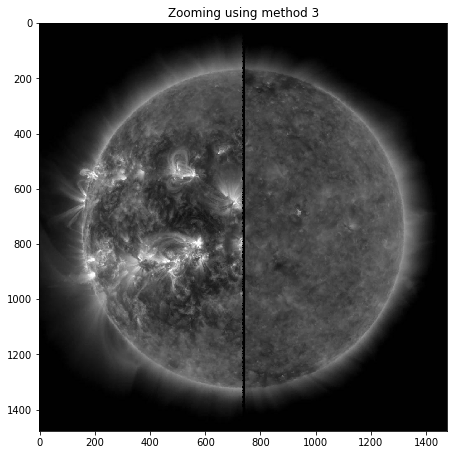

In [51]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_3(sun, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 3')
plt.imshow(zoomed_image)

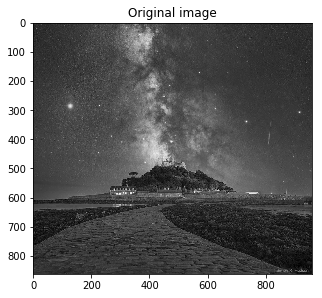

In [52]:
plt.figure(figsize=(5, 5))
plt.title('Original image')
plt.imshow(mount)

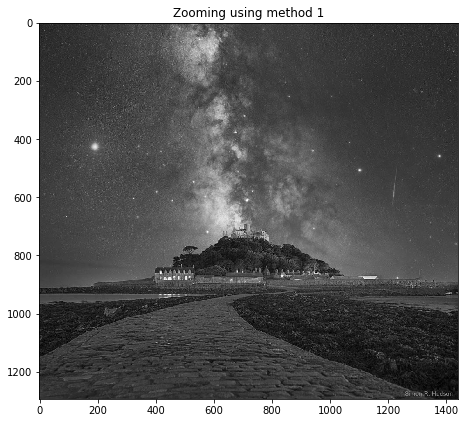

In [53]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_1(mount, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 1')
plt.imshow(zoomed_image)

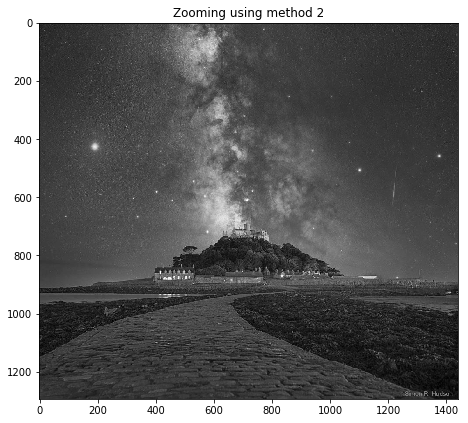

In [54]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_2(mount, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 2')
plt.imshow(zoomed_image)

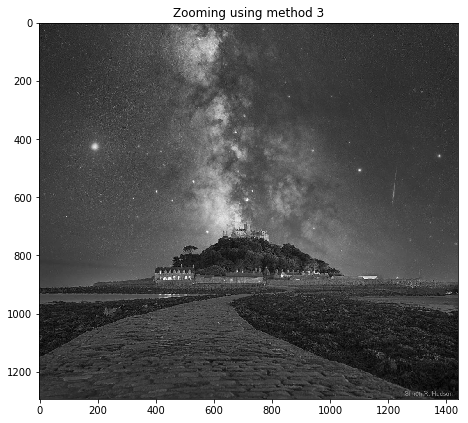

In [55]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_3(mount, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 3')
plt.imshow(zoomed_image)

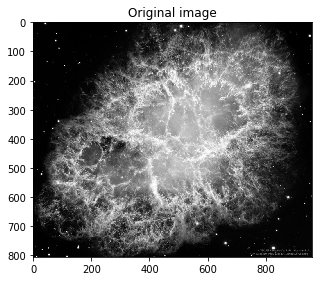

In [56]:
plt.figure(figsize=(5, 5))
plt.title('Original image')
plt.imshow(nebula)

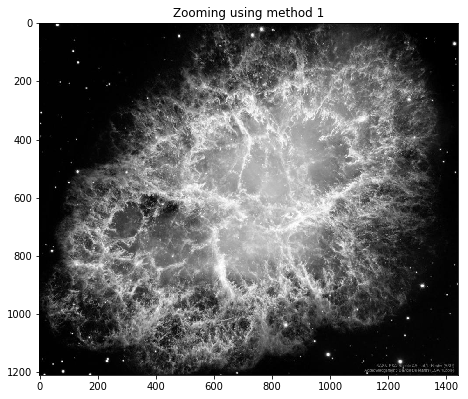

In [57]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_1(nebula, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 1')
plt.imshow(zoomed_image)

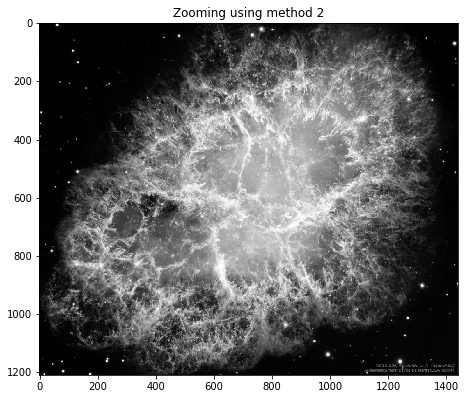

In [58]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_2(nebula, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 2')
plt.imshow(zoomed_image)

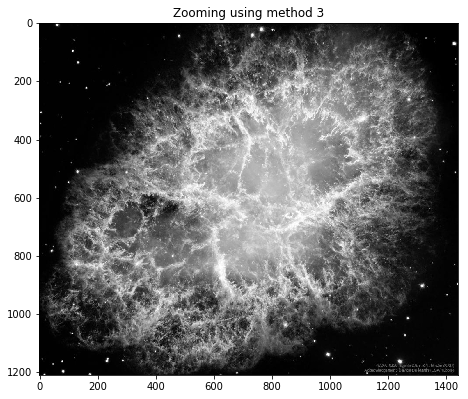

In [59]:
zoom_factor = 1.5
zoomed_image = zoom_image_nearest_neighbour_3(nebula, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.title('Zooming using method 3')
plt.imshow(zoomed_image)

Zoomed images using nearest neighbours almost remains same as original except <br>
size is increased.

Bilinear interpolation

In [60]:
# finding four nearest neighbours from a coordinate
# used top_left, top_right, bottom_left, bottom_right neigbours
# of original image 
def fill_nearest_neighbours_matrix(previous_x, previous_y, next_x, next_y):
    left_top_neighbour = (previous_x, previous_y)
    left_bottom_neighbour = (previous_x, next_y)
    right_top_neighbour = (next_x, previous_y)
    right_bottom_neighbour = (next_x, next_y)
    
    nearest_neighbours_matrix = np.ones((4,4), dtype='int')
    nearest_neighbours_matrix[0][1] = left_top_neighbour[0]
    nearest_neighbours_matrix[0][2] = left_top_neighbour[1]
    nearest_neighbours_matrix[0][3] = left_top_neighbour[0]*left_top_neighbour[1]
    
    nearest_neighbours_matrix[1][1] = left_bottom_neighbour[0]
    nearest_neighbours_matrix[1][2] = left_bottom_neighbour[1]
    nearest_neighbours_matrix[1][3] = left_bottom_neighbour[0]*left_bottom_neighbour[1]
    
    nearest_neighbours_matrix[2][1] = right_top_neighbour[0]
    nearest_neighbours_matrix[2][2] = right_top_neighbour[1]
    nearest_neighbours_matrix[2][3] = right_top_neighbour[0]*right_top_neighbour[1]
    
    nearest_neighbours_matrix[3][1] = right_bottom_neighbour[0]
    nearest_neighbours_matrix[3][2] = right_bottom_neighbour[1]
    nearest_neighbours_matrix[3][3] = right_bottom_neighbour[0]*right_bottom_neighbour[1]
    
    return nearest_neighbours_matrix

# bilinear interpolation
def bilinear_interpolation(image, zoom_factor):
    orig_width, orig_height = image.shape[1], image.shape[0]
    width, height = int(image.shape[1]*zoom_factor), int(image.shape[0]*zoom_factor)
    zoomed_image = np.zeros((height, width))
    for row in range(height):
        for col in range(width):
            x = row/zoom_factor
            y = col/zoom_factor
            previous_x = int(x)
            previous_y = int(y)
            next_x = int(x) + 1
            next_y = int(y) + 1
            # capping x and y to keep them inside image height and width
            if next_x >= orig_height:
                next_x = orig_height - 1
            if next_y >= orig_width:
                next_y = orig_width - 1
            nearest_neighbours_matrix = fill_nearest_neighbours_matrix(previous_x, previous_y, next_x, next_y)
            neigbour_pixels_matrix = np.zeros((4,1))
            # left top
            neigbour_pixels_matrix[0][0] = image[previous_x][previous_y]
            # left bottom
            neigbour_pixels_matrix[1][0] = image[previous_x][next_y]
            # right top
            neigbour_pixels_matrix[2][0] = image[next_x][previous_y]
            # right bottom
            neigbour_pixels_matrix[3][0] = image[next_x][next_y]
            # taking pseudo inverse since matrix can be singular also
            nearest_neighbours_matrix_inv =  np.linalg.pinv(nearest_neighbours_matrix)
            coefficient_matrix = np.matmul(nearest_neighbours_matrix_inv, neigbour_pixels_matrix)
            new_pixel_value = 0
            new_pixel_value += coefficient_matrix[0][0]
            new_pixel_value += coefficient_matrix[1][0]*previous_x
            new_pixel_value += coefficient_matrix[2][0]*previous_y
            new_pixel_value += coefficient_matrix[3][0]*previous_x*previous_y
            zoomed_image[row][col] = new_pixel_value
    return zoomed_image

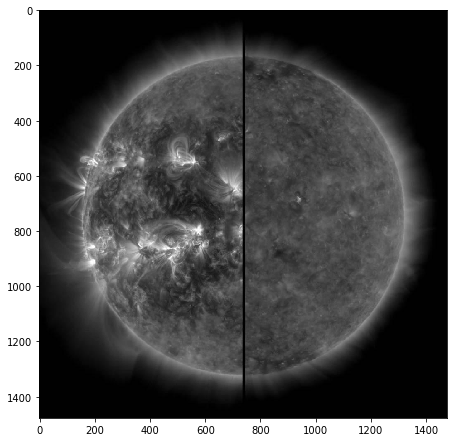

In [61]:
zoom_factor = 1.5
zoomed_image = bilinear_interpolation(sun, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.imshow(zoomed_image)

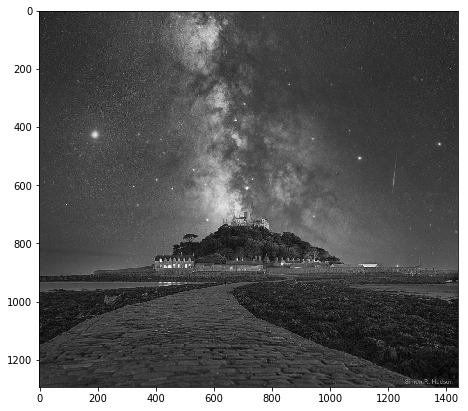

In [62]:
zoom_factor = 1.5
zoomed_image = bilinear_interpolation(mount, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.imshow(zoomed_image)

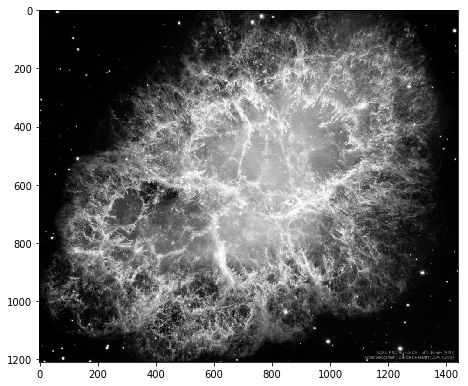

In [63]:
zoom_factor = 1.5
zoomed_image = bilinear_interpolation(nebula, zoom_factor)
plt.figure(figsize=(5*zoom_factor, 5* zoom_factor))
plt.imshow(zoomed_image)

Zoomed images using bilinear interpolation almost remains same as original except <br>
size is increased.

Test your program using three of your favorite images from the above set. Comment on the quality of the
two techniques and compare their computational complexity.

Three images tested above using all two techniques

Consider original image have size n`*`n. <br>
And zoomed image have size m`*`m <br> assuming zoom factor m`/`n <br>
Complexity of all zooming methods using nearest neighbour have O(m`*`m) time complexity <br>
since we are iterating over every pixel of zoomed image. <br>

Complexity of bilinear interpolation method have O(m`*`m) time complexity <br>
since we are iterating over every pixel of zoomed image. <br>
but since it involves calculating inverse of 4`*`4 matrix and matrix multiplication <br>
of 4`*`4 and 4`*`1 matrix, it requires 64`*`m`*`m operations since inverse of n`*`n <br>
takes O(n`**`3) time. <br>
Hence, bilinear interpolation is computationally more expensive than nearest neighbour <br>
by constant factor